In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib

import os

os.chdir('..')

import data_pulling
import get_portfolio
from evaluation_metrics import evaluate_portfolio

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

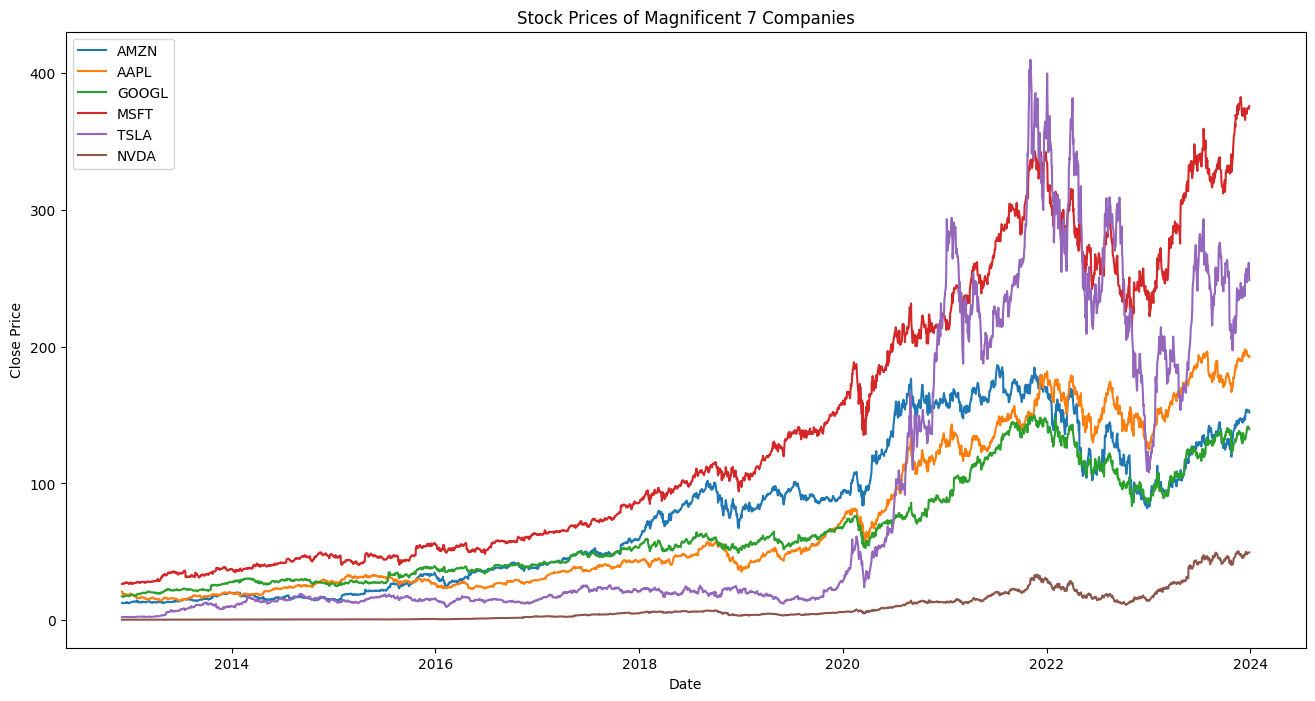

In [2]:
df = get_portfolio.get_data_files()

df_dict = {'AMZN': df['AMZN'], 'AAPL': df['AAPL'], 'GOOGL': df['GOOGL'], 'MSFT': df['MSFT'], 'TSLA': df['TSLA'], 'NVDA': df['NVDA']}

plt.figure(figsize=(16, 8))

for key in df_dict:
    plt.plot(df_dict[key].index, df_dict[key]['Close'], label=key)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices of Magnificent 7 Companies')
plt.legend()

plt.show()


In [3]:
import yfinance as yf

def get_spx():
    spx = yf.download('^GSPC', start='2012-12-31', end='2024-01-01', auto_adjust=True)
    spx = spx['Close']
    spx = spx.resample('D').ffill() # forward fill missing data
    return spx

spx = get_spx()

[*********************100%***********************]  1 of 1 completed


### Visualizing Buying and Selling Signals

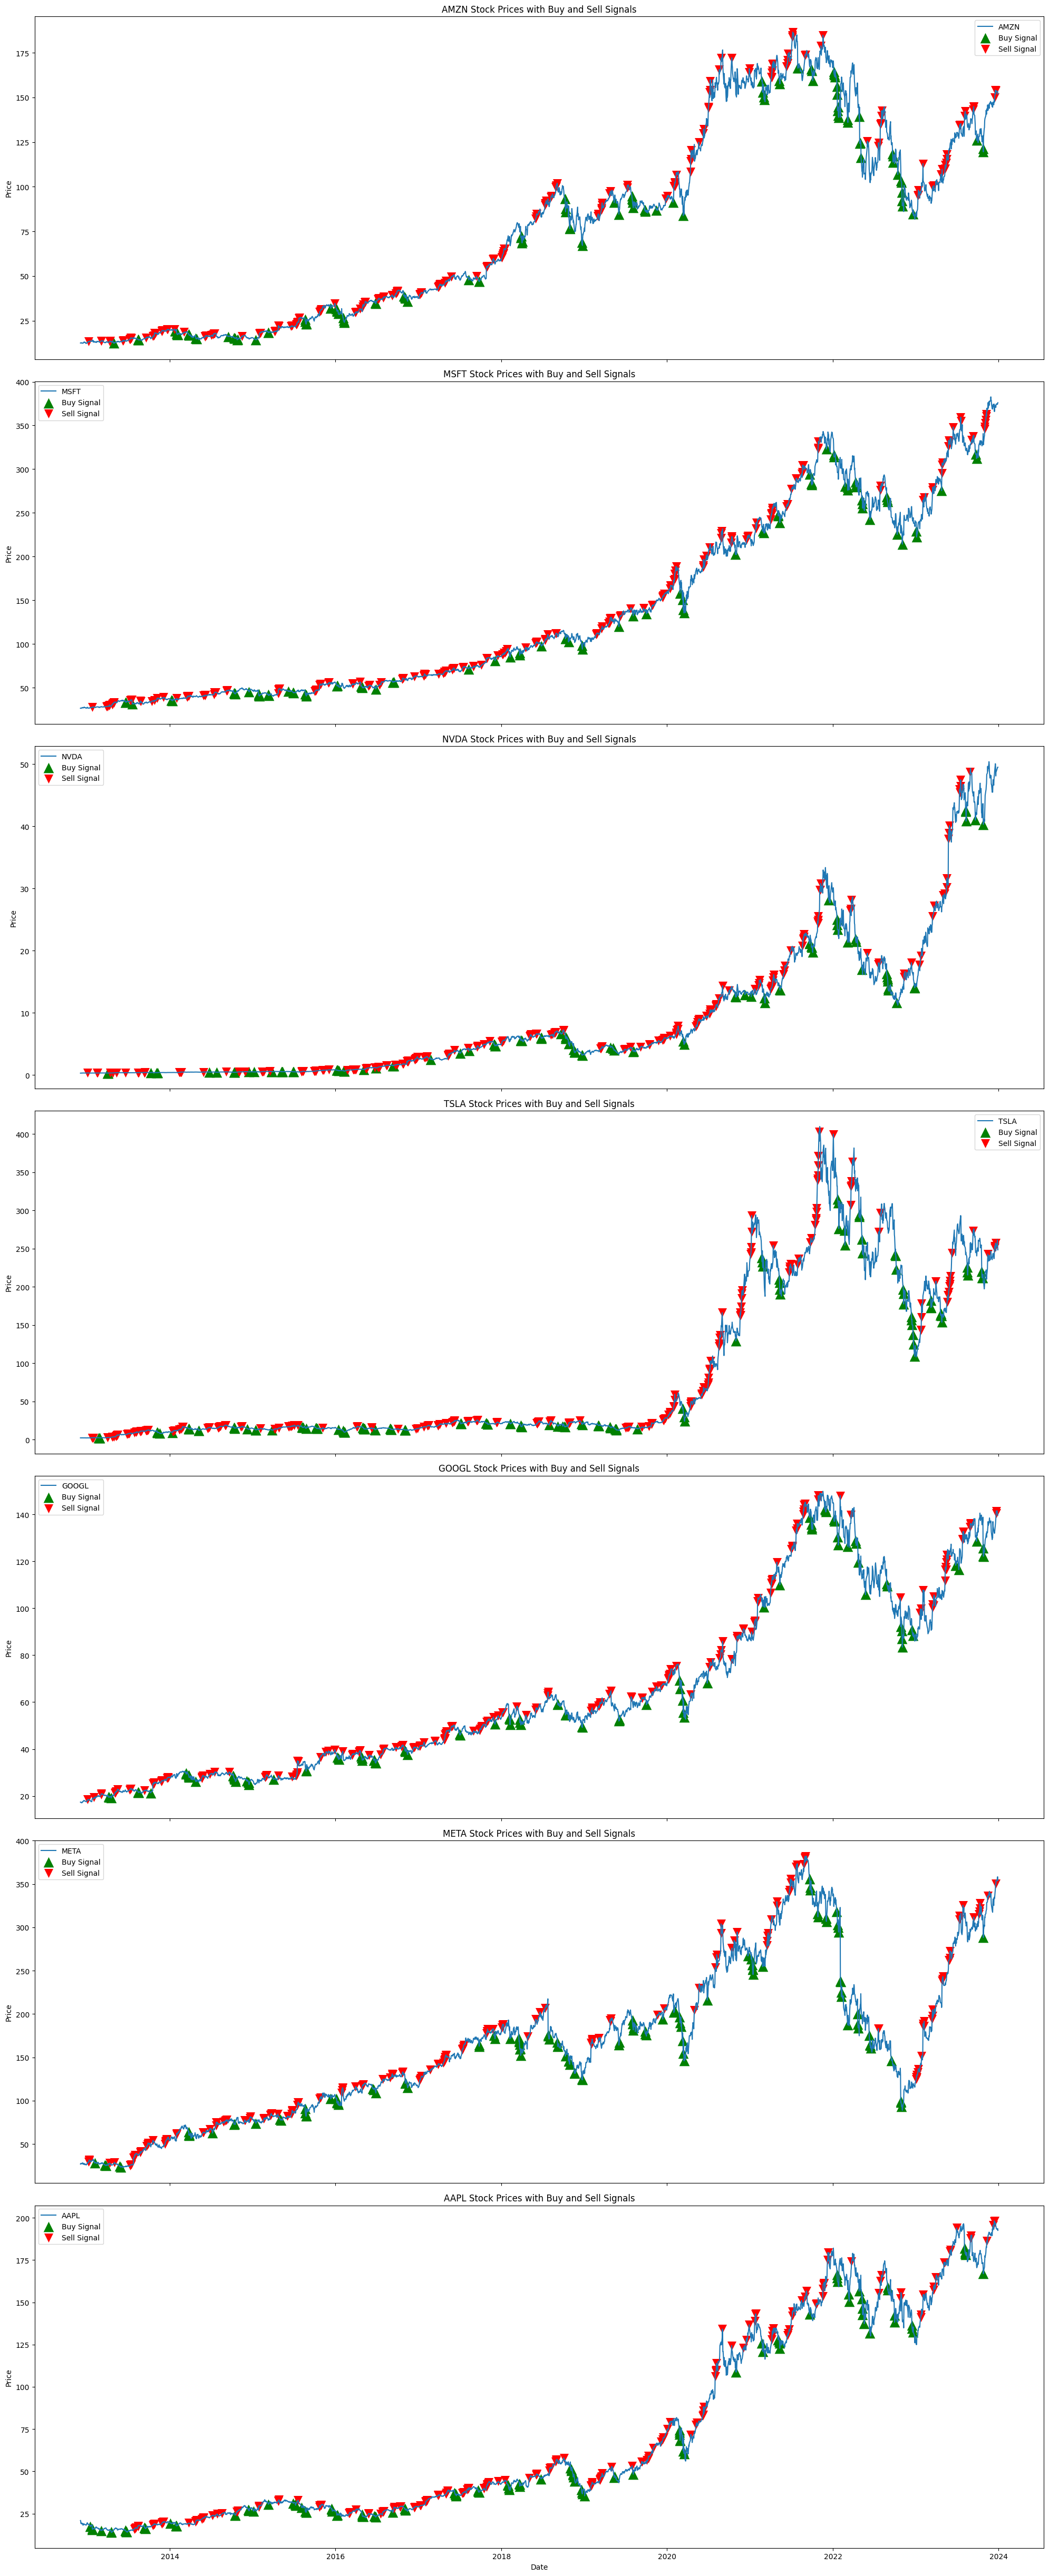

In [4]:
temp_dict = get_portfolio.get_data_files('temp')

num_stocks = len(temp_dict)

fig, axs = plt.subplots(num_stocks, 1, figsize=(20, 7 * num_stocks), sharex=True)

for i, key in enumerate(temp_dict):
    axs[i].plot(temp_dict[key].index, temp_dict[key]['Close'], label=key)
    
    axs[i].scatter(temp_dict[key].loc[temp_dict[key]['Buy Signal'] == True].index, 
                   temp_dict[key]['Close'][temp_dict[key]['Buy Signal'] == True], 
                   marker='^', color='g', label='Buy Signal', lw=0, s=200)

    axs[i].scatter(temp_dict[key].loc[temp_dict[key]['Sell Signal'] == True].index,
                   temp_dict[key]['Close'][temp_dict[key]['Sell Signal'] == True],
                   marker='v', color='r', label='Sell Signal', lw=0, s=150)

    axs[i].set_title(f'{key} Stock Prices with Buy and Sell Signals')
    axs[i].set_ylabel('Price')
    axs[i].legend()

plt.xlabel('Date')

plt.tight_layout()

plt.show()


### Finding best risk factor per trade 

How much risk should we allocate per trade based on ATR position sizing strategy

In [14]:
results = pd.DataFrame()
data_dict = get_portfolio.get_data_files('data')

results_list = []

for risk in np.arange(0.001, 0.01, 0.0005):
    print("Testing with risk level of", risk)
    temp_port = get_portfolio.generate_portfolio(data_dict, position_sizing='risk', risk_factor=risk)
    temp_eval = evaluate_portfolio(temp_port)

    results_list.append({'Risk Level': risk, 
                         'Total Return': temp_eval['Total Return'],
                         'Annual Return': temp_eval['Annual Return'],
                         'Annual Volatility': temp_eval['Annual Volatility'],
                         'Sharpe Ratio': temp_eval['Sharpe Ratio'],
                         'Sortino Ratio': temp_eval['Sortino Ratio'],
                         'Max Drawdown': temp_eval['Max Drawdown']
                         })
results = pd.DataFrame(results_list)

results = results.set_index('Risk Level')

Testing with risk level of 0.001
Testing with risk level of 0.0015
Testing with risk level of 0.002
Testing with risk level of 0.0025
Testing with risk level of 0.003
Testing with risk level of 0.0035
Testing with risk level of 0.004
Testing with risk level of 0.0045000000000000005
Testing with risk level of 0.005
Testing with risk level of 0.0055000000000000005
Testing with risk level of 0.006
Testing with risk level of 0.0065
Testing with risk level of 0.007
Testing with risk level of 0.007500000000000001
Testing with risk level of 0.008
Testing with risk level of 0.0085
Testing with risk level of 0.009000000000000001
Testing with risk level of 0.009500000000000001


In [15]:
print(results)

print("\n\nOptimal Risk Level According to Annual Return:", results['Annual Return'].idxmax())  

            Total Return  Annual Return  Annual Volatility  Sharpe Ratio  \
Risk Level                                                                 
0.0010        296.458869       0.133361          10.370212      0.136621   
0.0015        469.637740       0.171315          22.963088      0.178007   
0.0020        649.285694       0.200863          51.953441      0.187546   
0.0025        902.109152       0.233019          95.748154      0.192948   
0.0030       1051.198091       0.248660         193.245396      0.189236   
0.0035       1159.322105       0.258889         238.656258      0.203013   
0.0040        943.371660       0.237549         428.721683      0.205888   
0.0045        789.279374       0.219705         592.580810      0.207664   
0.0050        785.068093       0.219179         857.671759      0.211920   
0.0055        698.022555       0.207761        1126.892208      0.216036   
0.0060        491.864667       0.175397        1352.592733      0.222428   
0.0065      

### Compare Portfolio Performance to S&P500

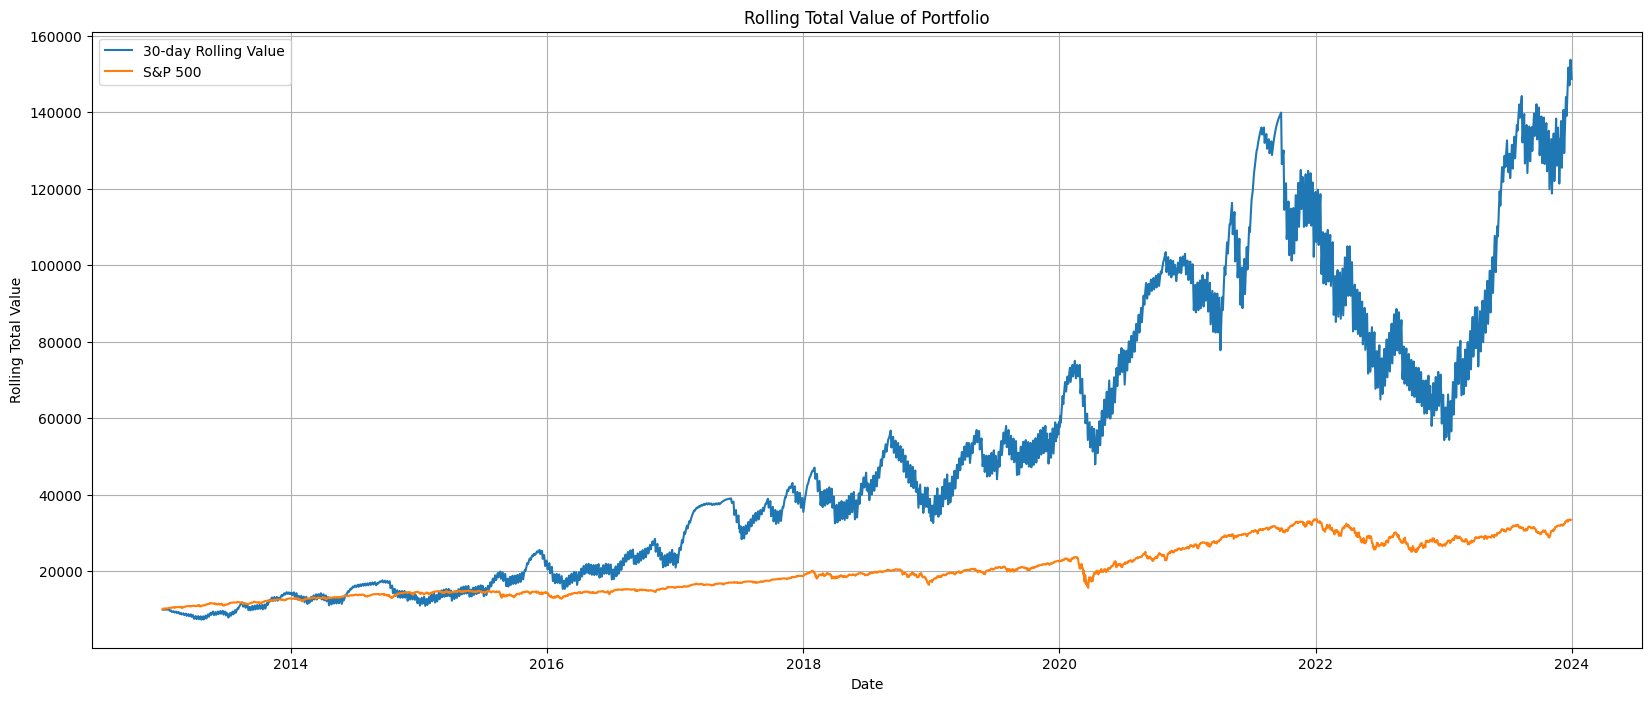

In [7]:
def get_portfolio_value():
    df = pd.read_csv('portfolio_versions/portfolio.csv')
    return df

portfolio = get_portfolio_value()

rolling_value_x = 30

# plot rolling total value of the portfolio for visibility
portfolio[f'Rolling {rolling_value_x}D Total Value'] = portfolio['Total'].ewm(span=rolling_value_x).mean()
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

plt.figure(figsize=(20, 8))
plt.plot(portfolio['Date'], portfolio[f'Rolling {rolling_value_x}D Total Value'], label=f'{rolling_value_x}-day Rolling Value')
plt.plot(spx/spx.iloc[0]*10000, label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Rolling Total Value')
plt.title('Rolling Total Value of Portfolio')
plt.legend()
plt.grid(True)
plt.show()


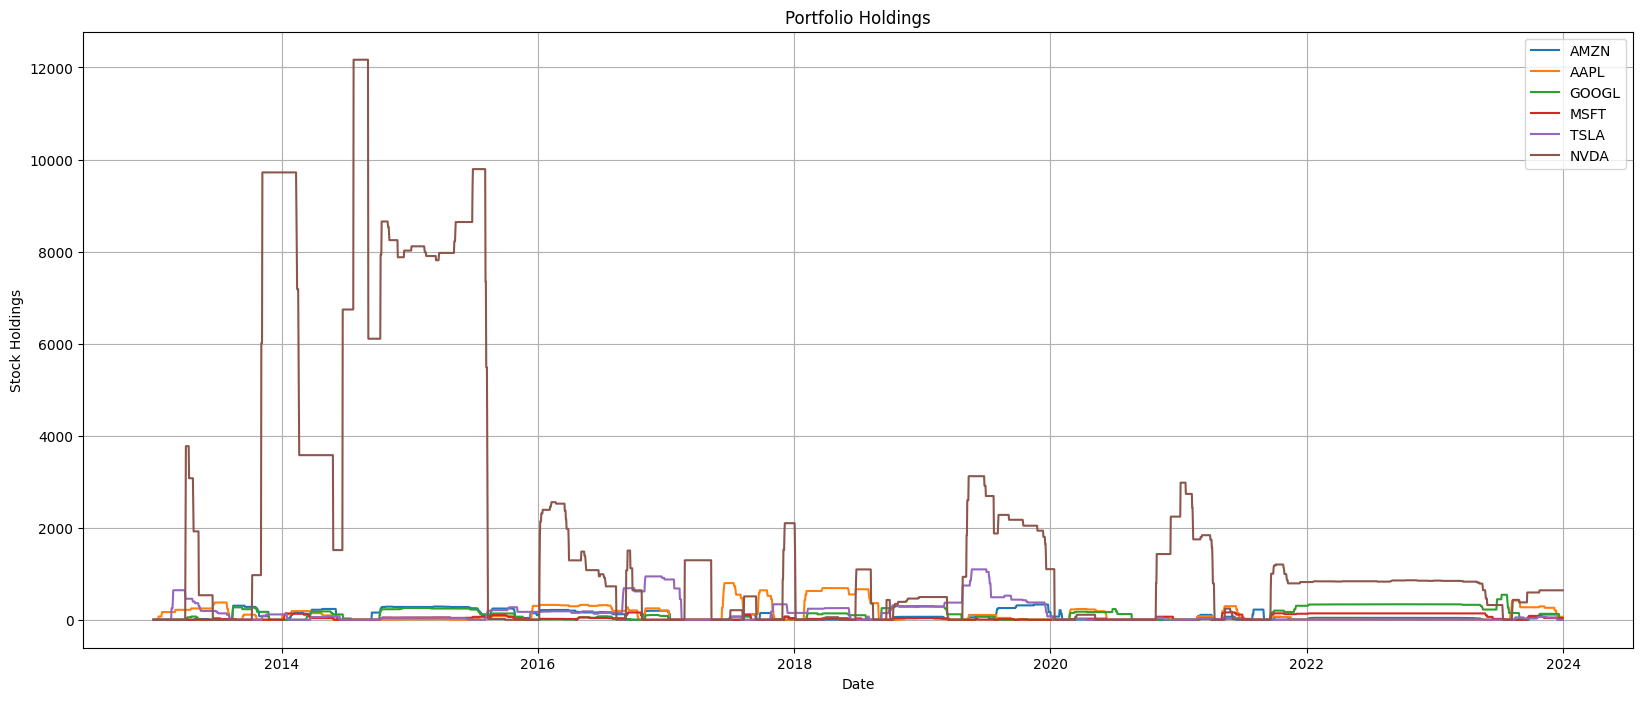

In [8]:
# see how the portfolio holdings change
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

plt.figure(figsize=(20, 8))
plt.plot(portfolio['Date'], portfolio['AMZN'], label='AMZN')
plt.plot(portfolio['Date'], portfolio['AAPL'], label='AAPL')
plt.plot(portfolio['Date'], portfolio['GOOGL'], label='GOOGL')
plt.plot(portfolio['Date'], portfolio['MSFT'], label='MSFT')
plt.plot(portfolio['Date'], portfolio['TSLA'], label='TSLA')
plt.plot(portfolio['Date'], portfolio['NVDA'], label='NVDA')

plt.xlabel('Date')
plt.ylabel('Stock Holdings')
plt.title('Portfolio Holdings')
plt.legend()
plt.grid(True)
plt.show()

In [9]:

portfolio.index = pd.to_datetime(portfolio['Date'])
evaluation_metrics = evaluate_portfolio(portfolio)
print("Portfolio Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")

spx = get_spx()
spx = spx.to_frame('Total')

spx_evaluation = evaluate_portfolio(spx)
print("\n\nS&P 500 Evaluation Metrics:")
for metric, value in spx_evaluation.items():
    print(f"{metric}: {value:.4f}")

[*********************100%***********************]  1 of 1 completed

Portfolio Evaluation Metrics:
Total Return: 1159.3221
Annual Return: 0.2589
Annual Volatility: 238.6563
Sharpe Ratio: 0.2030
Sortino Ratio: 7.9658
Max Drawdown: -0.9955


S&P 500 Evaluation Metrics:
Total Return: 234.4456
Annual Return: 0.1160
Annual Volatility: 0.1432
Sharpe Ratio: -2.1798
Sortino Ratio: -2.1946
Max Drawdown: -0.3392


In [10]:
# compare fixed vs risk allocation holding strategies:
# reload get_portfolio.py to get the updated generate_portfolio function

importlib.reload(get_portfolio)

data = get_portfolio.get_data_files()
fixed_portfolio = get_portfolio.generate_portfolio(data,position_sizing='fixed')

fixed_portfolio.tail()

# # fixed_portfolio.index = pd.to_datetime(fixed_portfolio['Date'])
fixed_portfolio_return = evaluate_portfolio(fixed_portfolio)

print("Fixed Portfolio Evaluation Metrics:")
for metric, value in fixed_portfolio_return.items():
    print(f"{metric}: {value:.4f}")

Fixed Portfolio Evaluation Metrics:
Total Return: 431.2938
Annual Return: 0.1639
Annual Volatility: 8231946.0247
Sharpe Ratio: 0.0706
Sortino Ratio: 92790.2898
Max Drawdown: -1.0000


Conclusion : 

position sizing 